In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import imutils

In [3]:
####### FRACTAL IMAGE COMPRESSION
# follows the algorithm outlined in "Introduction to Fractal Image Compression - Texas Instruments 1997".
# For readability variable names are the same as those given in the report. 
# The current version only works for square, greyscale images, so any test images must be converted to this format before compressing. 

## Transformations & helper functions 
# 1. Downscaling

def resize(img,scale):
    return imutils.resize(img, img.shape[0]//scale,img.shape[1]//scale)

# 2. rotations 

def rotate(img, theta):
    return imutils.rotate(img, theta) 

# 3. reflections -- rotates through x-axis

def reflect(img,direction):
    return img[::direction,:]

# 4. combining all transformations 

def transform(img,direction,theta):
    return(rotate(reflect(img,direction),theta))

# SSE measures distance between two blocks
def SSE(range_block, domain_block):
    return(np.sum(domain_block - range_block)**2)

# finds contrast value based on closed form solution given in "Introduction to Fractal Image Compression"
def get_alpha(range_block, domain_block):
    N = (domain_block.shape[0])**2
    alpha = (N*np.sum(domain_block*range_block)- np.sum(domain_block)*np.sum(range_block))/(N*np.sum(domain_block**2)- np.sum(domain_block**2))
    return(alpha)

# finds brightness value based on closed form solution given in "Introduction to Fractal Image Compression"
def get_t(range_block, domain_block,alpha):
    N = (domain_block.shape[0])**2
    t = (np.sum(range_block) - alpha*np.sum(domain_block))/N
    return(t)

In [4]:
## encoding function: takes an image and saves the best set of transformations and permutations in the fractal codebook. 
# codebook stores the position of each block and the best transformations to apply to them. 

def encode(img, range_size,domain_size):  
    codebook = [] # will be the final list of blocks and transformations
    perms = []    # will be the list of all blocks 
    D8 = [[r, theta] for r in [1,-1] for theta in [0, 90, 180, 270]] 

    # first, make all all domain blocks and their permutations, store in list.
    scale = domain_size//range_size
    count1 = img.shape[0]// domain_size
    for k in range(count1):
        for l in range(count1):
            Domain_block = resize(img[k:k+domain_size,l:l+domain_size], scale) # creates a domain block
            for r, theta in D8:
                perms.append((k,l, r, theta, transform(Domain_block, r, theta)))
    
    # now find the best transformations by minimising SSE between range and domain blocks
    count2 = img.shape[0] // range_size
    for i in range(count2):                                                          
        codebook.append([])
        for j in range(count2):
            codebook[i].append(None)
            best = float('inf')
            Range_block = img[i*range_size:(i+1)*range_size,j*range_size:(j+1)*range_size]    # creates a range block 
            for k, l, r, theta, Domain_block in perms:
                alpha= get_alpha(Range_block,Domain_block)
                t = get_t(Range_block,Domain_block, alpha)
                Domain_block = alpha*Domain_block + t
                d = SSE(Range_block,Domain_block)
                if d < best:
                    best = d
                    codebook[i][j] = (k, l, r, theta, alpha, t)
    return codebook

In [5]:
# decoding function: takes an initial image and a fractal codebook as input. Then iteratively applies maps from fractal codebook to the 
#initial image for a specified number of iterations. Returns a list of matrices which can be plotted as images. 
# The initial image must be the same size as the original image.
# For size argument, choose the same value as the range_size value when encoding.

def decode(init_img,codebook,size,iter=6):
    range_size,domain_size = size,size
    iterations = [init_img]
    img = np.zeros((init_img.shape[0],init_img.shape[1]))
    for i_iter in range(iter):
        for i in range(len(codebook)):
            for j in range(len(codebook[i])):
                k, l, r, theta, alpha, t = codebook[i][j]
                Domain_block = iterations[-1][k:k+range_size,l:l+range_size]
                Range_block = alpha*transform(Domain_block, r, theta)+t
                img[i*domain_size:(i+1)*domain_size,j*domain_size:(j+1)*domain_size] = Range_block
        iterations.append(img)
        img = np.zeros((init_img.shape[0],init_img.shape[1]))
    return iterations

In [6]:
## make a greyscale image --- only dealing with greyscale images for this project.
# to return a colour image we could split an RGB image into its 3 colour channels and apply the encoding/decoding to each channel, then stitch it back together. 

def make_test_img(img,d,x_offset, y_offset,scale=1):
    r,g,b = img[:,:,0],img[:,:,1],img[:,:,2]
    grey = 0.2989*r + 0.587*g + 0.114*b
    return(resize(grey[y_offset:y_offset+d,x_offset:x_offset+d],scale))

def find_comp_ratio(img,codebook):
    import sys
    return(print(f"Original size: {sys.getsizeof(img)}"),print(f"Compressed size: {sys.getsizeof(codebook)}"),print(f"Compression ratio: {sys.getsizeof(img)/sys.getsizeof(codebook)}"))


In [11]:
## test images

fern = cv2.imread("images/black spleenwort fern.jpg")[...,::-1] 
gibbon = cv2.imread("images/gibbon.jpg")[...,::-1]

In [18]:
## TESTING
# Here load two images: an image to compress and an initial image for decoding. Make sure they are the same size. Then you can change the range and domain block
# sizes when encoding to try out different compression ratios. Just beware that it becomes very slow for block sizes under 8. 


test_gibbon = make_test_img(gibbon,100,100,2)
test_fern = make_test_img(fern,100,100,2)

enc = encode(test_gibbon,16,32)
dec = decode(test_fern,enc,16)

find_comp_ratio(test_gibbon,enc)

Original size: 80128
Compressed size: 120
Compression ratio: 667.7333333333333


(None, None, None)

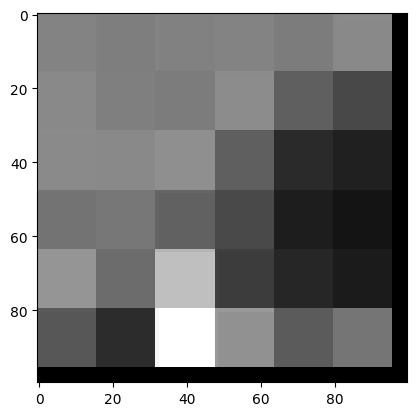

In [17]:
# changing the value plots different iterations. 

plt.imshow(dec[6],cmap = "grey")